In [1]:
from PIL import Image # Reading and manipulating images
import numpy as np # Math stuff
import matplotlib.pyplot as plt # Plot stuff
from matplotlib.patches import Rectangle
import particle.literals
plt.rcParams['text.usetex'] = True
import pandas as pd

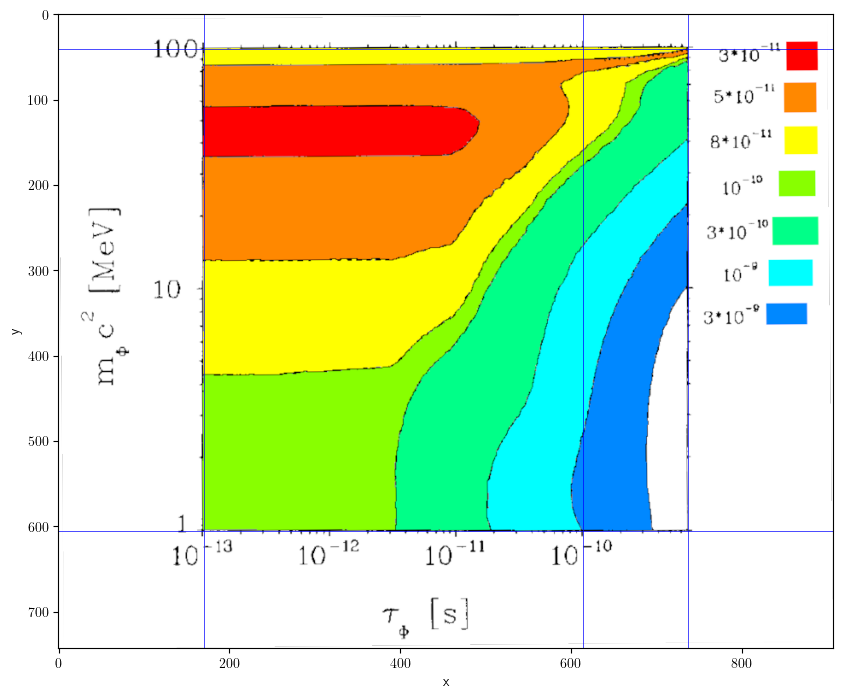

In [2]:
img = Image.open('SINDRUM_color.png')
plt.figure(figsize=(10,10))
plt.imshow(np.asarray(img))
plt.xlabel('x')
plt.ylabel('y')

plt.axvline(170, lw=0.5, c='b') # 0.1ps
plt.axvline(614, lw=0.5, c='b') # 100ps
plt.axvline(737, lw=0.5, c='b')

plt.axhline(605, lw=0.5, c='b') # 1e-3 GeV
plt.axhline(40, lw=0.5, c='b') # 0.1 GeV


In [3]:
colordict = {
    (255, 0, 0, 255): 3e-11,
    (255, 136, 0, 255): 5e-11,
    (255, 255, 0, 255): 8e-11,
    (136, 255, 0, 255): 1e-10,
    (0, 255, 136, 255): 3e-10,
    (0, 255, 255, 255): 1e-9,
    (0, 136, 255, 255):3e-9
}

In [4]:
def y2ma(y):
    a = -2/(605-40)
    b = -1-a*40
    return 10**(a*y+b)

def ma2y(m):
    a = -2/(605-40)
    b = -1-a*40
    return (np.log10(m)-b)/a

def x2tau(x):
    a = 3/(614-170)
    b = -1-a*170
    return 10**(a*x+b)

def tau2x(tau):
    a = 3/(614-170)
    b = -1-a*170
    return (np.log10(m)-b)/a    

In [5]:
def BR_ratio(mP, ml, ma):
    fa = 1000
    x = ma**2/mP**2
    f0 = 1-8*x+8*x**3-x**4-12*x**2*np.log(x)
    f1 = 1+9*x-9*x**2-x**3+6*x*(1+x)*np.log(x)
    return mP**4/(1536*np.pi**2*fa**2*ml**2)*(f0+16*ml**2/mP**2*f1)/(1-ml**2/mP**2)**2

In [6]:
mpi = particle.literals.pi_plus.mass/1000
me = particle.literals.e_minus.mass/1000

BR = lambda x: BR_ratio(mpi, me, x)*1.2352e-4

In [7]:
hbar = 6.582119569e-13 # GeV ps
fa = 1000

def tau_alp(ma):
    ml = me
    return 8*np.pi*fa**2*hbar/(ma*ml**2*np.sqrt(1-4*ml**2/ma**2))

In [8]:
br = []
tau_list = []
for x in range(170, 737):
    col = img.getpixel((x, 200))
    if col in colordict.keys():
        br.append(colordict[col])
        tau_list.append(x2tau(x))

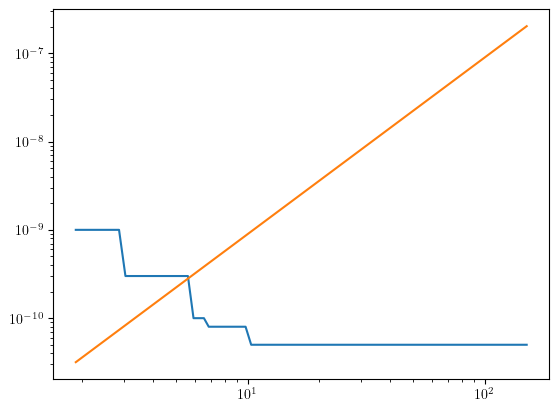

In [9]:
m0 = y2ma(200)
tau0 = tau_alp(m0)
plt.loglog([np.sqrt(tau0/t) for t in tau_list], br)
plt.loglog([np.sqrt(tau0/t) for t in tau_list], [tau0/t*BR(m0) for t in tau_list])

In [10]:
m_list = []
c_bound = []
for y in range(605, 39, -1):
    m0 = y2ma(y)
    tau0 = tau_alp(m0)
    for x in range(737, 169, -1):
        col = img.getpixel((x, y))
        if col in colordict.keys():
            br_exp = colordict[col]
            c_ell = np.sqrt(tau0/x2tau(x))
            br_th = c_ell**2*BR(m0)
            if br_th > br_exp:
                m_list.append(m0)
                c_bound.append(c_ell)
                break

/tmp/ipykernel_9079/3927282558.py:6: RuntimeWarning: invalid value encountered in sqrt
  return 8*np.pi*fa**2*hbar/(ma*ml**2*np.sqrt(1-4*ml**2/ma**2))


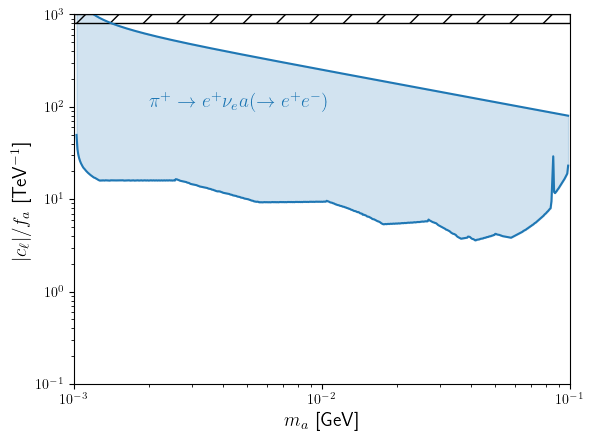

In [11]:
plt.loglog(m_list, c_bound)
plt.loglog(m_list, [np.sqrt(tau_alp(m)/0.1) for m in m_list], c='tab:blue')
plt.fill_between(m_list, c_bound, [np.sqrt(tau_alp(m)/0.1) for m in m_list], color='tab:blue', alpha=0.2)
plt.fill_between([1e-3, 1e-1], [814, 814], [1e3, 1e3], color='none', edgecolor='k', hatch='/')
plt.ylim([0.1, 1000])
plt.xlim([1e-3, 1e-1])
plt.xlabel(r'$m_a$ [GeV]', fontsize=14)
plt.ylabel(r'$|c_\ell|/f_a$ [TeV$^{-1}$]', fontsize=14)
plt.annotate(r'$\pi^+\to e^+ \nu_e a(\to e^+e^-)$', (2e-3, 1e2), color='tab:blue', fontsize=14)
plt.savefig('pi_displaced.png')

In [13]:
pd.DataFrame({'ma_GeV': m_list, 'cl_inf': c_bound, 'cl_sup': [np.sqrt(tau_alp(m)/0.1) for m in m_list]}).to_csv('../data/meson_lept/pienua_displaced.csv', index=False)